5/20 (Mon) | Experiment

# Correlation Analyses of Automatically Calculated UF Measures

## 1. Introduction

This notebook evaluate the reliability of the UF measures calculated based on the proposed annotation system. More specifically, I conduct correlation analyses between manually and automatically calculated measures.
In addition, I conduct the same analyses for different perceived fluency score groups separatelly.

The target measures are follows:
- Speed fluency
    - Articulation rate (AR)
- Breakdown fluency
    - Mid-clause pause ratio (MCPR)
    - End-clause pause ratio (ECPR)
    - Mid-clause pause duration (MCPD)
    - End-clause pause duration (ECPD)
    - Pause ratio (PR)
    - Pause duration (PD)
- Repair fluency
    - Disfluency ratio (DR)
- Composite
    - Speech rate (SR)
    - Mean length of run (MLR)

Note that, in dialogue task, I use mean values of turn-level measures.

Before starting the evaluation, the following code block loads required packages and define global variables.

In [1]:
from typing import List, Tuple, Generator, Optional
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from utils.mfr import logit_2_rating

DATA_DIR = Path("/home/matsuura/Development/app/feature_extraction_api/experiment/data")

TASK = ["Arg_Oly", "Cartoon", "RtSwithoutRAA", "RtSwithRAA", "WoZ_Interview"]

TARGET_UF_MEASURES = [
    "articulation_rate", "mid_clause_pause_ratio", "end_clause_pause_ratio",
    "mid_clause_p-dur", "end_clause_p-dur", "pause_ratio", "mean_pause_duration",
    "dysfluency_ratio", "speech_rate", "mean_length_of_run"
]

---

## 2. Define Functions

This section defines functions for correlation analyses.
The following code block defines a function to load measures.

In [2]:
def filter_by_rating(task: str, df_uf: pd.DataFrame, rating_filter: List[int]) -> pd.DataFrame:
    pf_path = DATA_DIR / f"{task}/12_PF_Rating/pf_rating.csv"
    df_pf = pd.read_csv(pf_path)
    uid_list = df_pf["uid"].to_numpy()

    logit_path = pf_path.parent / "logit.csv"
    threshold_path = logit_path.parent / "threshold.csv"
    
    df_logit = pd.read_csv(logit_path, index_col=0)
    rating_list = logit_2_rating(df_logit["theta"], threshold_path)

    mask = np.full(rating_list.shape, False, dtype=bool)
    for rating in rating_filter:
        mask = mask | (rating_list == rating)
    
    uid_list = uid_list[mask]

    if task != "WoZ_Interview":
        df_uf_filtered = df_uf.loc[uid_list, :]
        return df_uf_filtered

    mask = None
    for uid in uid_list:
        uid_prefix = f"{int(uid):03}_"
        uid_mask = df_uf.index.str.startswith(uid_prefix)
        
        if mask is None:
            mask = uid_mask
        mask = mask | uid_mask

    return df_uf[mask]

def add_pause_ratio(df_uf: pd.DataFrame) -> pd.DataFrame:
    df_uf.loc[:, "pause_ratio"] = df_uf["mid_clause_pause_ratio"] + df_uf["end_clause_pause_ratio"]

    return df_uf

def calculate_mean_uf_measures(df_uf: pd.DataFrame) -> pd.DataFrame:
    data = []

    for uid in range(1, 86):
        uid = str(uid).zfill(3)

        mask = df_uf.index.str.startswith(uid)
        if mask.sum() == 0:
            continue

        df_uf_masked = df_uf[mask]
        mean_uf_measures = df_uf_masked.mean(axis=0, skipna=True)
        
        row = {
            "uid": uid   
        }
        for measure_name in df_uf.columns:
            row[measure_name] = mean_uf_measures[measure_name]
        data.append(row)

    df_uf_mean = pd.DataFrame.from_dict(data).set_index("uid", drop=True)

    return df_uf_mean

def load_measures(task_list: List[str], rating_filter: Optional[List[int]] =None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_uf_manu_list = []
    df_uf_auto_list = []
    
    for task in task_list:
        uf_manu_path = DATA_DIR / f"{task}/09_UF_Measures/uf_measures_manu_pruned.csv"
        uf_auto_path = uf_manu_path.parent / "uf_measures_auto_pruned.csv"

        df_uf_manu = pd.read_csv(uf_manu_path, index_col="uid")
        df_uf_auto = pd.read_csv(uf_auto_path, index_col="uid")

        if rating_filter is not None:
            df_uf_manu = filter_by_rating(task, df_uf_manu, rating_filter)
            df_uf_auto = filter_by_rating(task, df_uf_auto, rating_filter)

        if task == "WoZ_Interview":
            df_uf_manu = calculate_mean_uf_measures(df_uf_manu)
            df_uf_auto = calculate_mean_uf_measures(df_uf_auto)

        df_uf_manu_list.append(df_uf_manu)
        df_uf_auto_list.append(df_uf_auto)

    df_uf_manu = pd.concat(df_uf_manu_list, axis=0)
    df_uf_auto = pd.concat(df_uf_auto_list, axis=0)

    df_uf_manu = add_pause_ratio(df_uf_manu)
    df_uf_auto = add_pause_ratio(df_uf_auto)

    df_uf_manu = df_uf_manu[TARGET_UF_MEASURES].sort_index()
    df_uf_auto = df_uf_auto[TARGET_UF_MEASURES].sort_index()

    return df_uf_manu, df_uf_auto

The following code block conducts a correlation analysis.

In [3]:
def correlation_analysis(task: str, df_uf_manu: pd.DataFrame, df_uf_auto: pd.DataFrame) -> pd.DataFrame:
    fig = plt.figure(figsize=(15, 10))    
    ncols = 4
    nrows = (len(TARGET_UF_MEASURES) + ncols - 1) // ncols

    data = []
    columns = ["UF measure", "r", "p", "sig"]
    for i, measure in enumerate(TARGET_UF_MEASURES):
        ax = fig.add_subplot(nrows, ncols, i + 1)

        measure_manu = df_uf_manu[measure]
        measure_auto = df_uf_auto[measure]

        r, p = pearsonr(measure_manu, measure_auto)
        if p < 0.001:
            sig = "***"
        elif p < 0.01:
            sig = "**"
        elif p < 0.05:
            sig = "*"
        elif p < 0.1:
            sig = "."
        else:
            sig = ""

        data.append([measure, r, p, sig])

        ax.scatter(measure_manu, measure_auto)
        ax.set_title(f"[{measure}] r={r:.03f}{sig}")
        ax.set_xlabel(f"Manually Calculated Measure")
        ax.set_ylabel(f"Automatically Calculate Measure")

    df_pearsonr = pd.DataFrame(data, columns=columns).set_index("UF measure", drop=True)

    fig.suptitle(f"[{task}] Scatter Plots of Manually and Automatically UF Measures (N={len(df_uf_manu)})", fontweight="bold")
    fig.tight_layout()
    plt.show()

    return df_pearsonr

---

## 3. Correlation Analyses

This section conducts the correlation analyses.

### 3.1. All Speakers

Firstly, UF measures obtained from all tasks are analyzed.

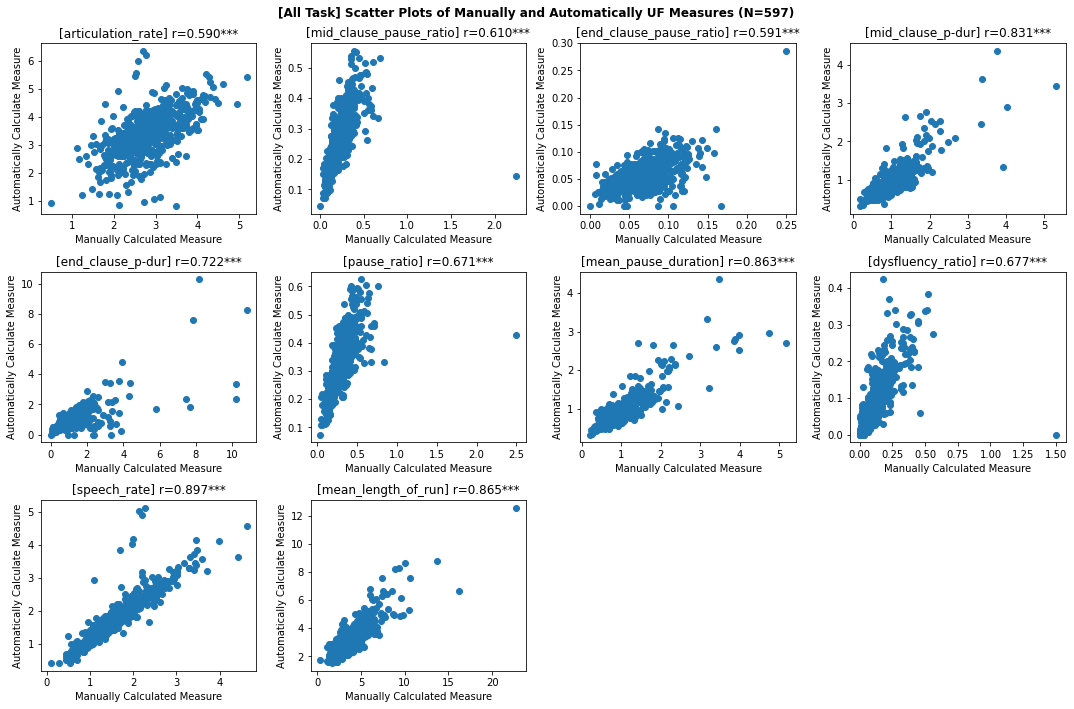

,r,p,sig
UF measure,,,
articulation_rate,0.589634,3.523876e-57,***
mid_clause_pause_ratio,0.610434,3.098169e-62,***
end_clause_pause_ratio,0.591114,1.582718e-57,***
mid_clause_p-dur,0.831293,6.865514e-154,***
end_clause_p-dur,0.722316,2.264776e-97,***
pause_ratio,0.671170,2.159764e-79,***
mean_pause_duration,0.862956,1.511823e-178,***
dysfluency_ratio,0.677067,2.803532e-81,***
speech_rate,0.897389,1.388261e-213,***


In [4]:
df_uf_manu, df_uf_auto = load_measures(TASK)
correlation_analysis("All Task", df_uf_manu, df_uf_auto)

The following five code blocks conduct the analyses for each task.

**Arg_Oly**

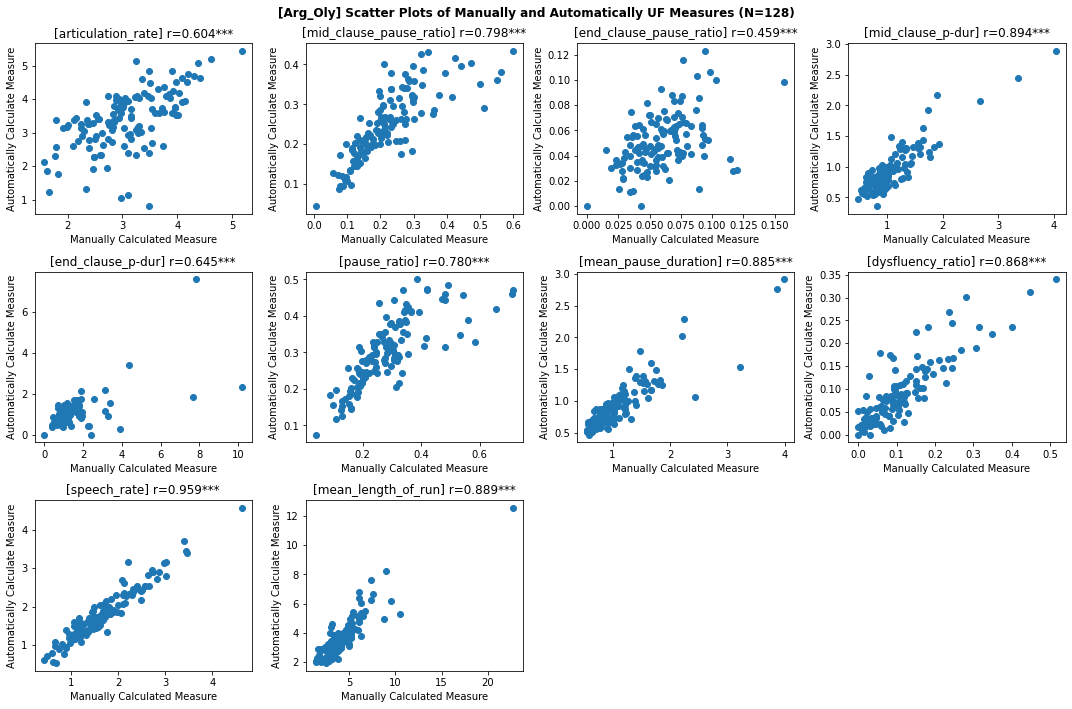

,r,p,sig
UF measure,,,
articulation_rate,0.603590,4.660326e-14,***
mid_clause_pause_ratio,0.798123,1.663451e-29,***
end_clause_pause_ratio,0.458654,5.192646e-08,***
mid_clause_p-dur,0.894129,8.637202e-46,***
end_clause_p-dur,0.645094,2.059634e-16,***
pause_ratio,0.779560,2.258493e-27,***
mean_pause_duration,0.885212,1.056815e-43,***
dysfluency_ratio,0.868332,3.467728e-40,***
speech_rate,0.958631,1.296455e-70,***


In [5]:
task = "Arg_Oly"
df_uf_manu, df_uf_auto = load_measures([task])
correlation_analysis(task, df_uf_manu, df_uf_auto)

**Cartoon**

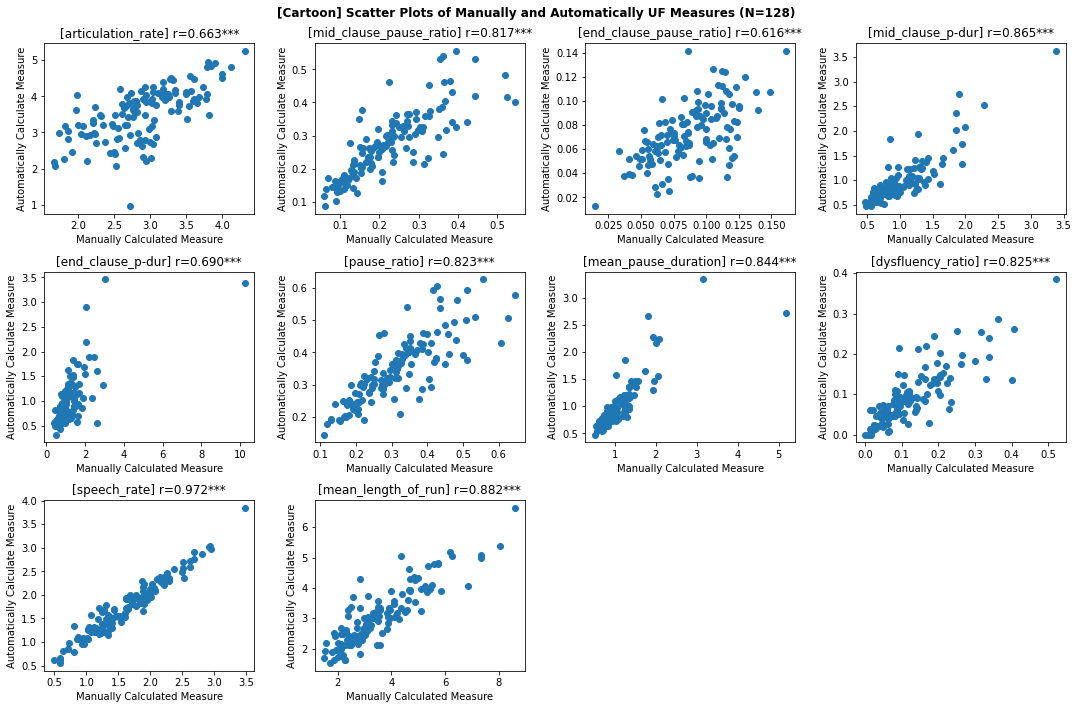

,r,p,sig
UF measure,,,
articulation_rate,0.662920,1.539219e-17,***
mid_clause_pause_ratio,0.817323,5.849219e-32,***
end_clause_pause_ratio,0.616133,9.846097e-15,***
mid_clause_p-dur,0.865010,1.495012e-39,***
end_clause_p-dur,0.689903,2.128440e-19,***
pause_ratio,0.823424,8.438912e-33,***
mean_pause_duration,0.844125,6.498815e-36,***
dysfluency_ratio,0.825443,4.373439e-33,***
speech_rate,0.971919,4.907339e-81,***


In [6]:
task = "Cartoon"
df_uf_manu, df_uf_auto = load_measures([task])
correlation_analysis(task, df_uf_manu, df_uf_auto)

**RtSwithoutRAA**

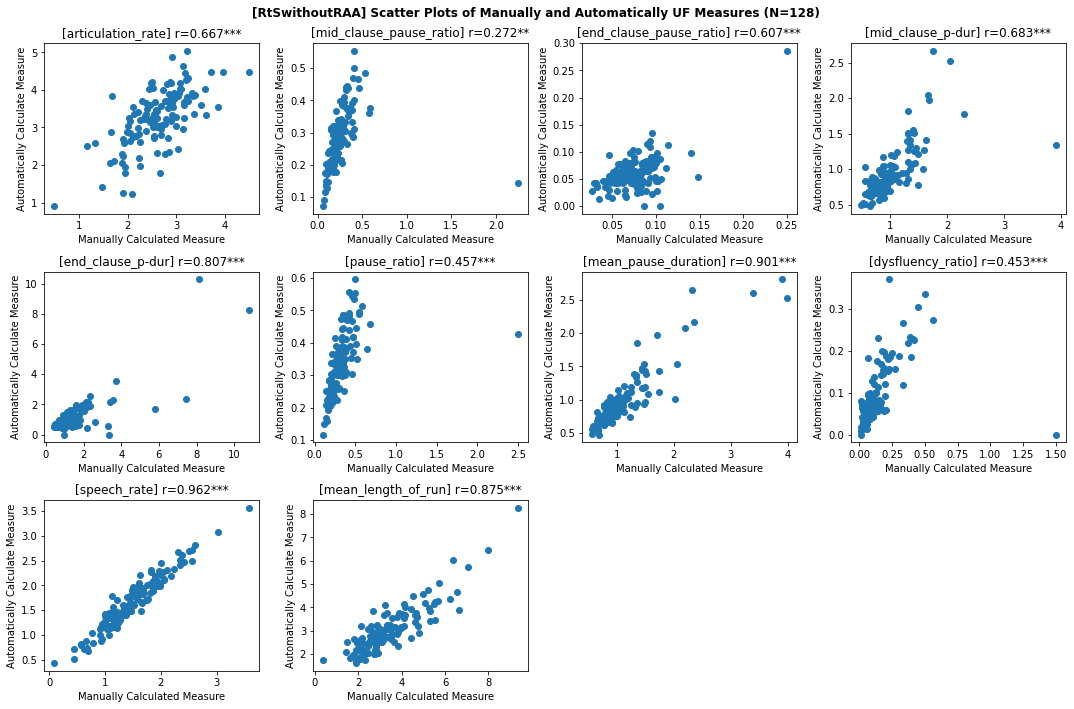

,r,p,sig
UF measure,,,
articulation_rate,0.667370,7.834117e-18,***
mid_clause_pause_ratio,0.272356,1.869990e-03,**
end_clause_pause_ratio,0.606527,3.258329e-14,***
mid_clause_p-dur,0.682748,6.926443e-19,***
end_clause_p-dur,0.806936,1.345252e-30,***
pause_ratio,0.456787,5.973305e-08,***
mean_pause_duration,0.900817,1.755147e-47,***
dysfluency_ratio,0.452824,8.018253e-08,***
speech_rate,0.961821,9.125141e-73,***


In [7]:
task = "RtSwithoutRAA"
df_uf_manu, df_uf_auto = load_measures([task])
correlation_analysis(task, df_uf_manu, df_uf_auto)

**RtSwithRAA**

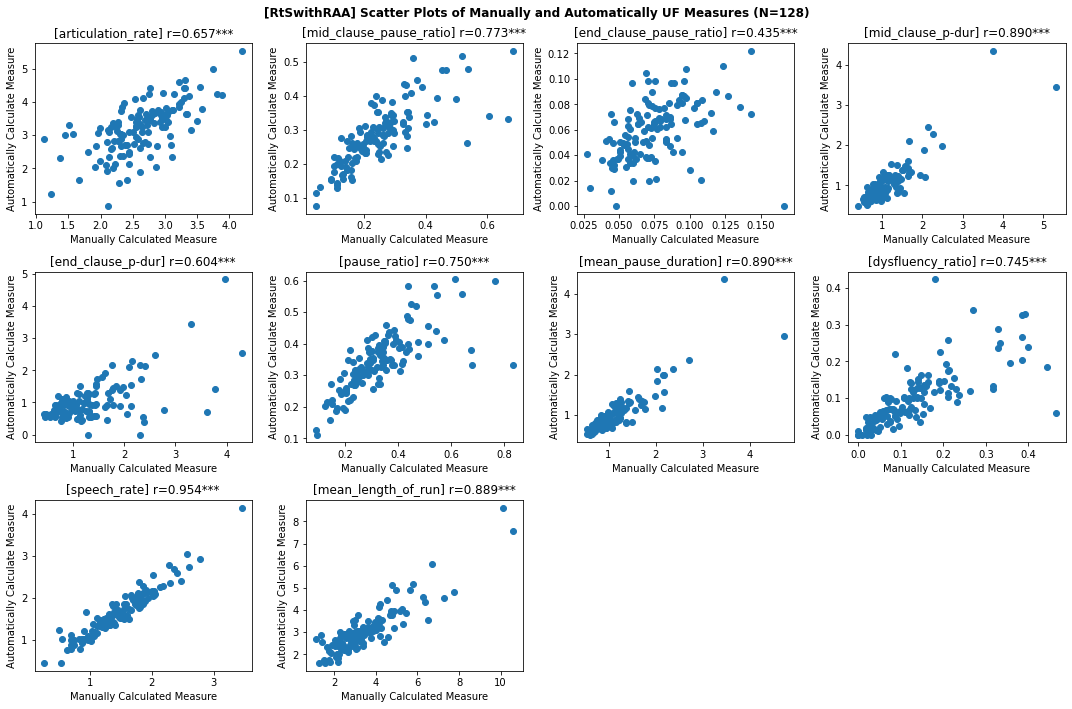

,r,p,sig
UF measure,,,
articulation_rate,0.656952,3.740176e-17,***
mid_clause_pause_ratio,0.773241,1.079482e-26,***
end_clause_pause_ratio,0.434886,2.904445e-07,***
mid_clause_p-dur,0.890385,6.839372e-45,***
end_clause_p-dur,0.604366,4.241141e-14,***
pause_ratio,0.749655,2.439831e-24,***
mean_pause_duration,0.890003,8.407834e-45,***
dysfluency_ratio,0.744658,7.123348e-24,***
speech_rate,0.953946,9.643402e-68,***


In [8]:
task = "RtSwithRAA"
df_uf_manu, df_uf_auto = load_measures([task])
correlation_analysis(task, df_uf_manu, df_uf_auto)

**WoZ_Interview**

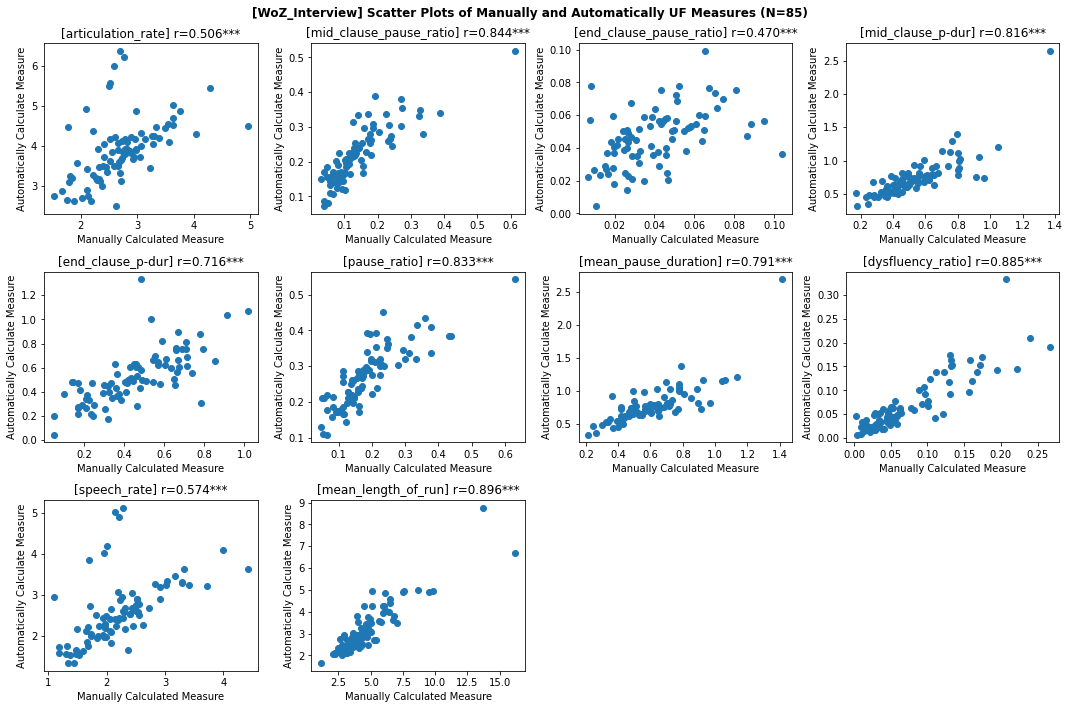

,r,p,sig
UF measure,,,
articulation_rate,0.505805,7.897640e-07,***
mid_clause_pause_ratio,0.843644,3.928584e-24,***
end_clause_pause_ratio,0.470214,5.607791e-06,***
mid_clause_p-dur,0.815942,1.884664e-21,***
end_clause_p-dur,0.715630,1.400914e-14,***
pause_ratio,0.832940,4.876290e-23,***
mean_pause_duration,0.791283,2.031118e-19,***
dysfluency_ratio,0.884638,3.093951e-29,***
speech_rate,0.574353,9.064875e-09,***


In [9]:
task = "WoZ_Interview"
df_uf_manu, df_uf_auto = load_measures([task])
correlation_analysis(task, df_uf_manu, df_uf_auto)

### 3.2. Beginners

The following code blocks conduct the analyses of *beginners'* speech.

**Arg_Oly**

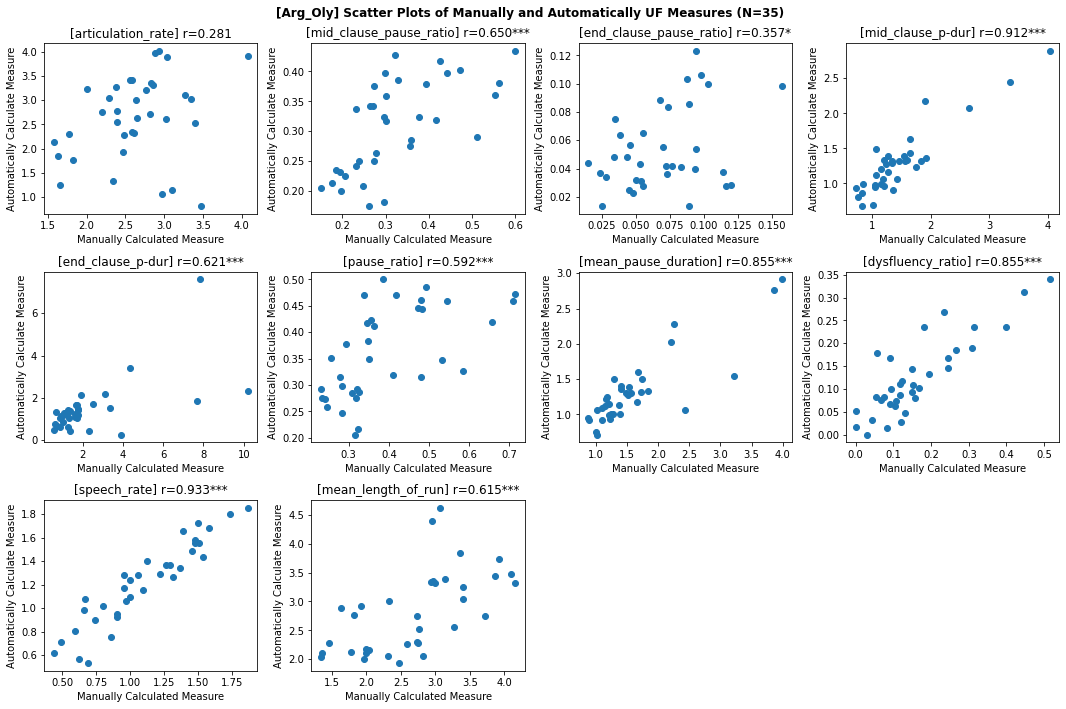

,r,p,sig
UF measure,,,
articulation_rate,0.281236,1.017108e-01,
mid_clause_pause_ratio,0.649798,2.397970e-05,***
end_clause_pause_ratio,0.357232,3.514050e-02,*
mid_clause_p-dur,0.911839,2.618084e-14,***
end_clause_p-dur,0.621294,6.804972e-05,***
pause_ratio,0.592165,1.786910e-04,***
mean_pause_duration,0.855372,5.971057e-11,***
dysfluency_ratio,0.855079,6.160166e-11,***
speech_rate,0.933265,3.113268e-16,***


In [10]:
task = "Arg_Oly"
rating_filter = [0, 1, 2]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)

**Cartoon**

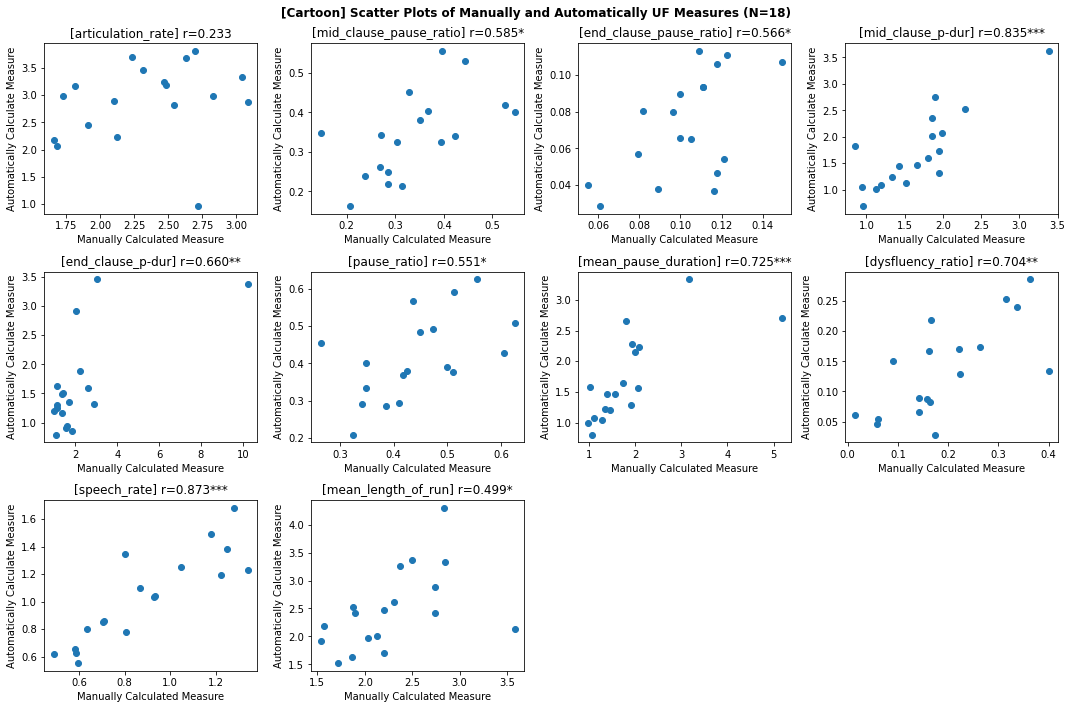

,r,p,sig
UF measure,,,
articulation_rate,0.233301,0.351491,
mid_clause_pause_ratio,0.584909,0.010782,*
end_clause_pause_ratio,0.566499,0.014240,*
mid_clause_p-dur,0.834560,0.000017,***
end_clause_p-dur,0.660240,0.002863,**
pause_ratio,0.551169,0.017747,*
mean_pause_duration,0.725199,0.000660,***
dysfluency_ratio,0.703979,0.001111,**
speech_rate,0.872847,0.000002,***


In [11]:
task = "Cartoon"
rating_filter = [0, 1, 2]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)

**RtSwithoutRAA**

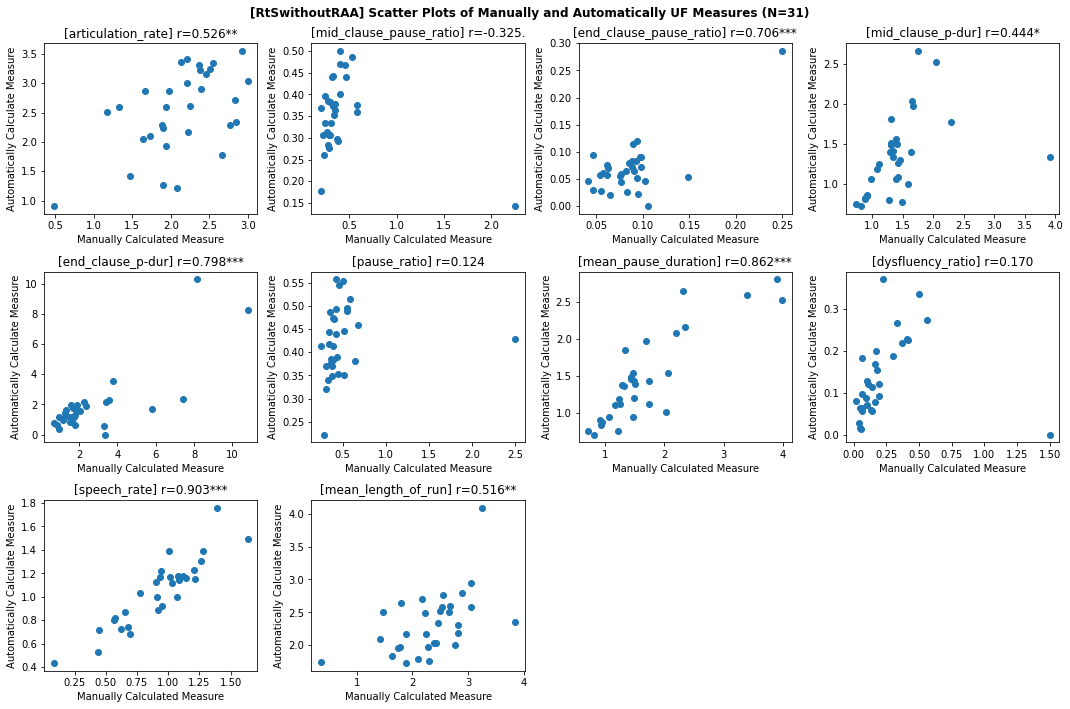

,r,p,sig
UF measure,,,
articulation_rate,0.526076,2.367803e-03,**
mid_clause_pause_ratio,-0.325122,7.431678e-02,.
end_clause_pause_ratio,0.706033,9.102426e-06,***
mid_clause_p-dur,0.443537,1.244660e-02,*
end_clause_p-dur,0.798327,7.415625e-08,***
pause_ratio,0.124270,5.053728e-01,
mean_pause_duration,0.861983,4.682203e-10,***
dysfluency_ratio,0.170045,3.604274e-01,
speech_rate,0.902817,3.798048e-12,***


In [12]:
task = "RtSwithoutRAA"
rating_filter = [0, 1, 2]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)

**RtSwithRAA**

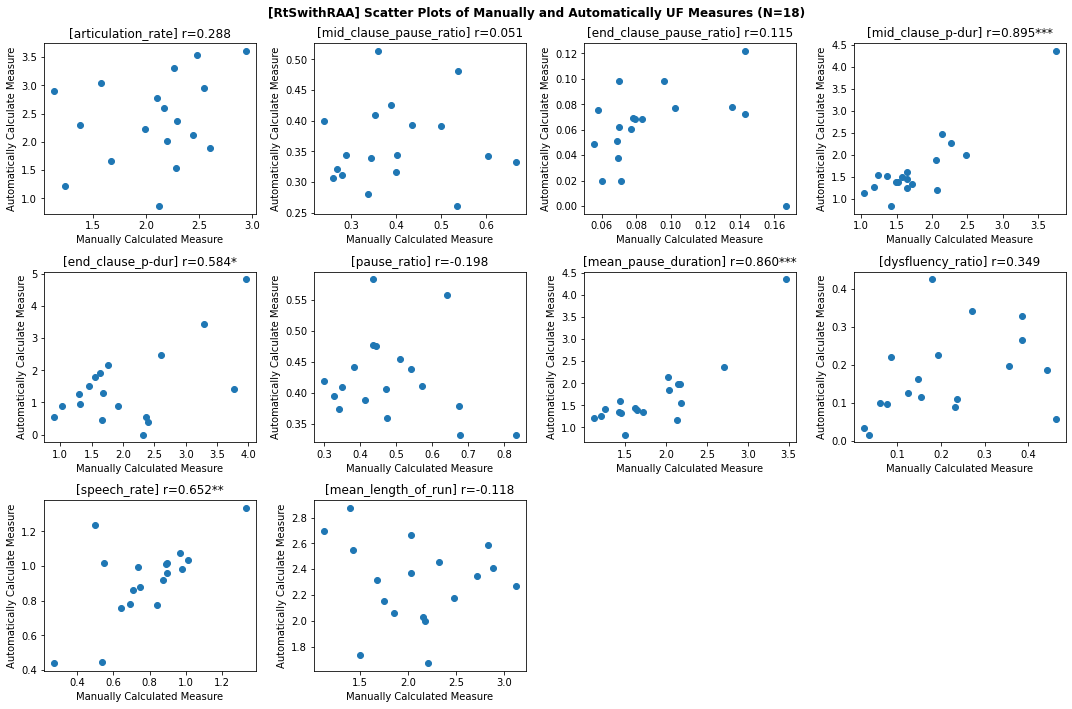

,r,p,sig
UF measure,,,
articulation_rate,0.288006,2.464776e-01,
mid_clause_pause_ratio,0.051027,8.406366e-01,
end_clause_pause_ratio,0.114592,6.507161e-01,
mid_clause_p-dur,0.894774,5.407439e-07,***
end_clause_p-dur,0.583669,1.099111e-02,*
pause_ratio,-0.198426,4.299312e-01,
mean_pause_duration,0.859809,4.786653e-06,***
dysfluency_ratio,0.349465,1.551717e-01,
speech_rate,0.651882,3.374107e-03,**


In [13]:
task = "RtSwithRAA"
rating_filter = [0, 1, 2]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)

**WoZ_Interview**

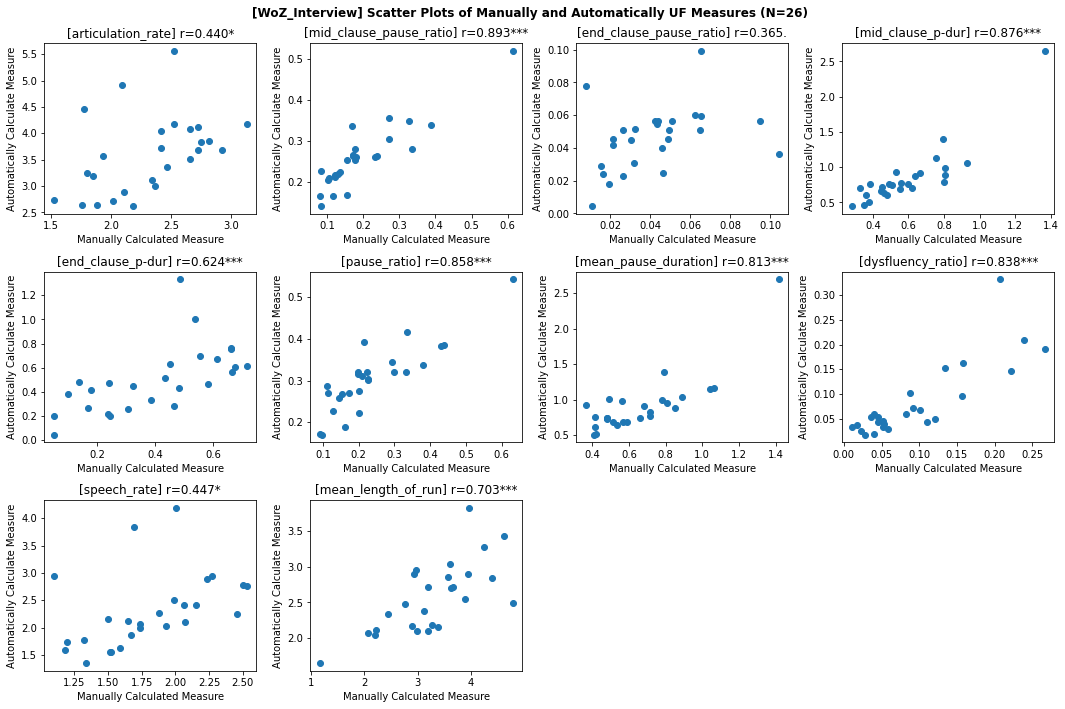

,r,p,sig
UF measure,,,
articulation_rate,0.440002,2.448785e-02,*
mid_clause_pause_ratio,0.893429,8.142885e-10,***
end_clause_pause_ratio,0.364973,6.675686e-02,.
mid_clause_p-dur,0.876477,4.372576e-09,***
end_clause_p-dur,0.623999,6.578838e-04,***
pause_ratio,0.858341,2.052555e-08,***
mean_pause_duration,0.812985,4.490080e-07,***
dysfluency_ratio,0.838497,8.886115e-08,***
speech_rate,0.446865,2.209919e-02,*


In [14]:
task = "WoZ_Interview"
rating_filter = [0, 1]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)

### 3.3. Intermediate Speakers

The following code blocks conduct the analyses of *intemediate speakers'* speech.

**Arg_Oly**

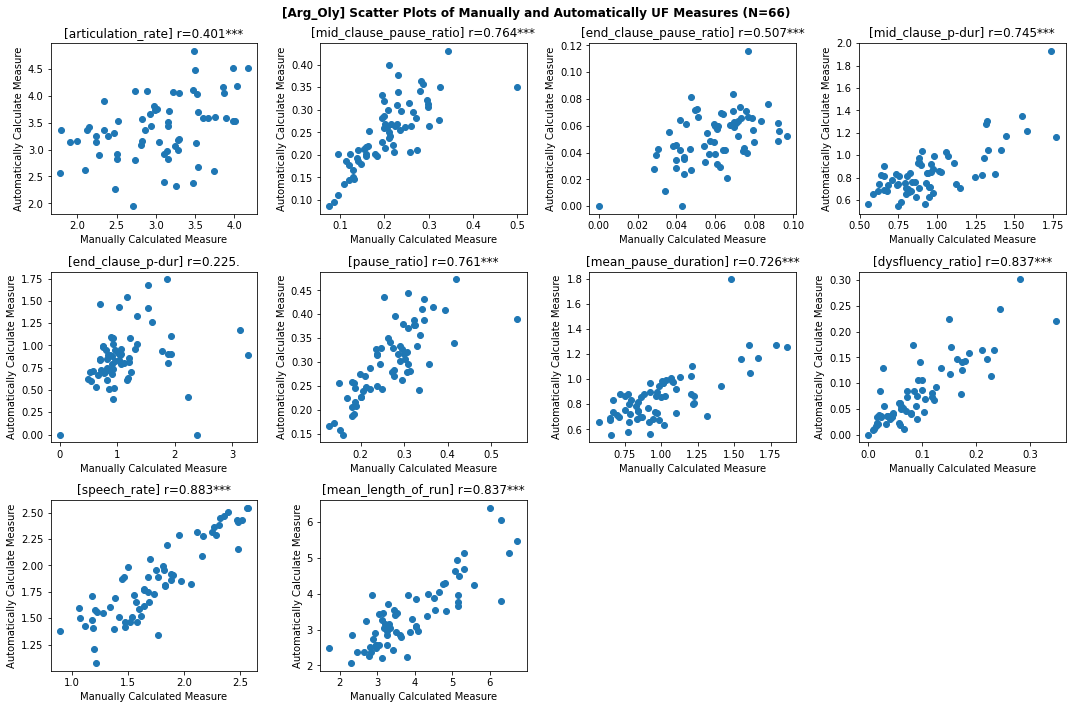

,r,p,sig
UF measure,,,
articulation_rate,0.401460,8.350821e-04,***
mid_clause_pause_ratio,0.763917,8.608161e-14,***
end_clause_pause_ratio,0.507436,1.370674e-05,***
mid_clause_p-dur,0.744726,7.577373e-13,***
end_clause_p-dur,0.224757,6.962545e-02,.
pause_ratio,0.760747,1.250271e-13,***
mean_pause_duration,0.725608,5.505174e-12,***
dysfluency_ratio,0.836955,2.073431e-18,***
speech_rate,0.883407,9.569241e-23,***


In [15]:
task = "Arg_Oly"
rating_filter = [3, 4, 5]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)

**Cartoon**

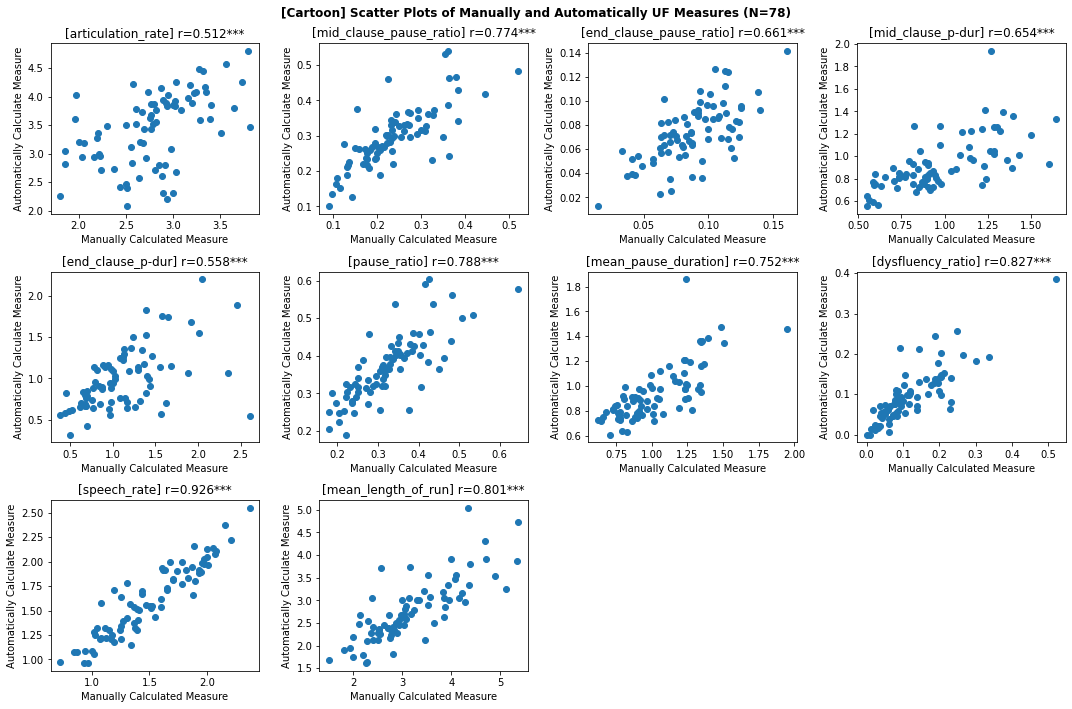

,r,p,sig
UF measure,,,
articulation_rate,0.512411,1.620094e-06,***
mid_clause_pause_ratio,0.774315,9.200668e-17,***
end_clause_pause_ratio,0.661065,4.488337e-11,***
mid_clause_p-dur,0.653530,8.802328e-11,***
end_clause_p-dur,0.558499,1.076001e-07,***
pause_ratio,0.787995,1.125489e-17,***
mean_pause_duration,0.752342,2.010980e-15,***
dysfluency_ratio,0.827297,1.013974e-20,***
speech_rate,0.926398,5.681620e-34,***


In [16]:
task = "Cartoon"
rating_filter = [3, 4, 5]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)

**RtSwithoutRAA**

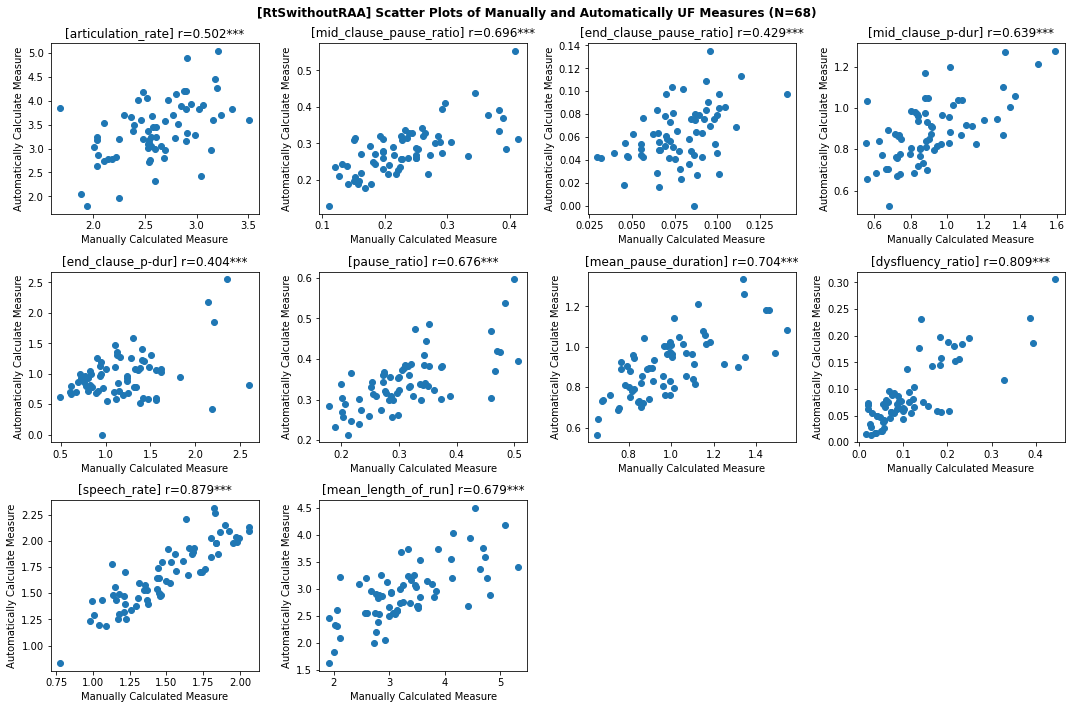

,r,p,sig
UF measure,,,
articulation_rate,0.502457,1.264933e-05,***
mid_clause_pause_ratio,0.696403,4.279403e-11,***
end_clause_pause_ratio,0.428683,2.650695e-04,***
mid_clause_p-dur,0.638839,4.572359e-09,***
end_clause_p-dur,0.403936,6.355036e-04,***
pause_ratio,0.675919,2.542434e-10,***
mean_pause_duration,0.703777,2.171981e-11,***
dysfluency_ratio,0.808799,7.284654e-17,***
speech_rate,0.879274,6.103687e-23,***


In [17]:
task = "RtSwithoutRAA"
rating_filter = [3, 4, 5]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)

**RtSwithRAA**

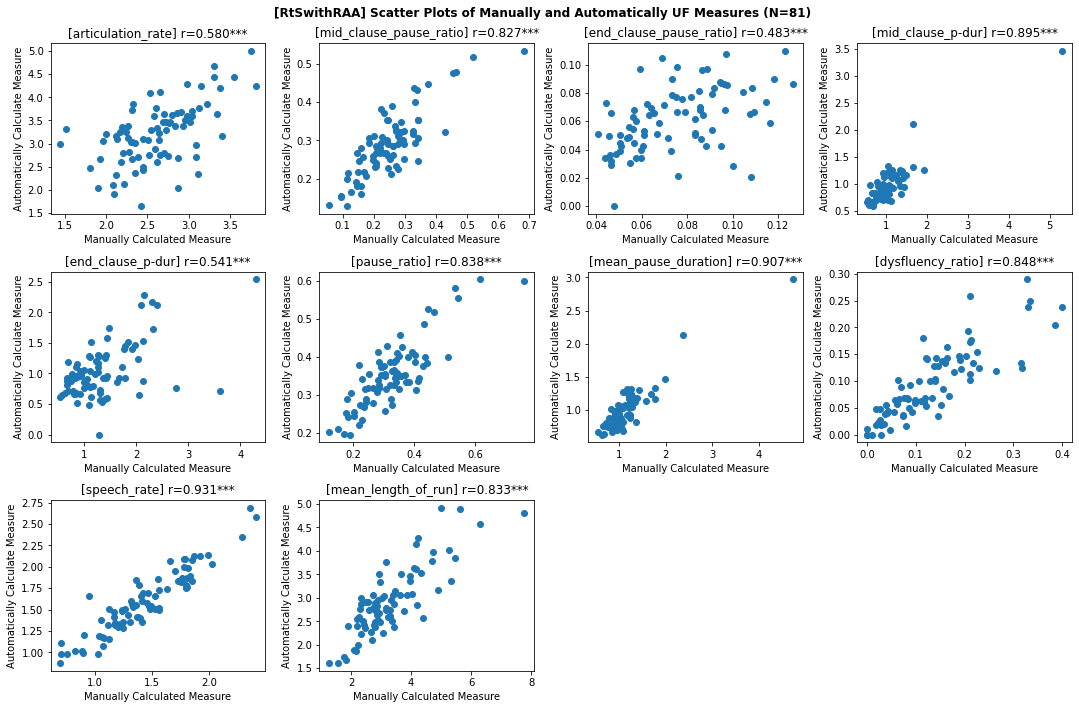

,r,p,sig
UF measure,,,
articulation_rate,0.580363,1.356694e-08,***
mid_clause_pause_ratio,0.827354,1.743138e-21,***
end_clause_pause_ratio,0.483257,4.884650e-06,***
mid_clause_p-dur,0.894809,2.141028e-29,***
end_clause_p-dur,0.541284,1.813708e-07,***
pause_ratio,0.838458,1.582215e-22,***
mean_pause_duration,0.907227,1.913665e-31,***
dysfluency_ratio,0.847846,1.798183e-23,***
speech_rate,0.931051,2.469505e-36,***


In [18]:
task = "RtSwithRAA"
rating_filter = [3, 4, 5]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)

**WoZ_Interview**

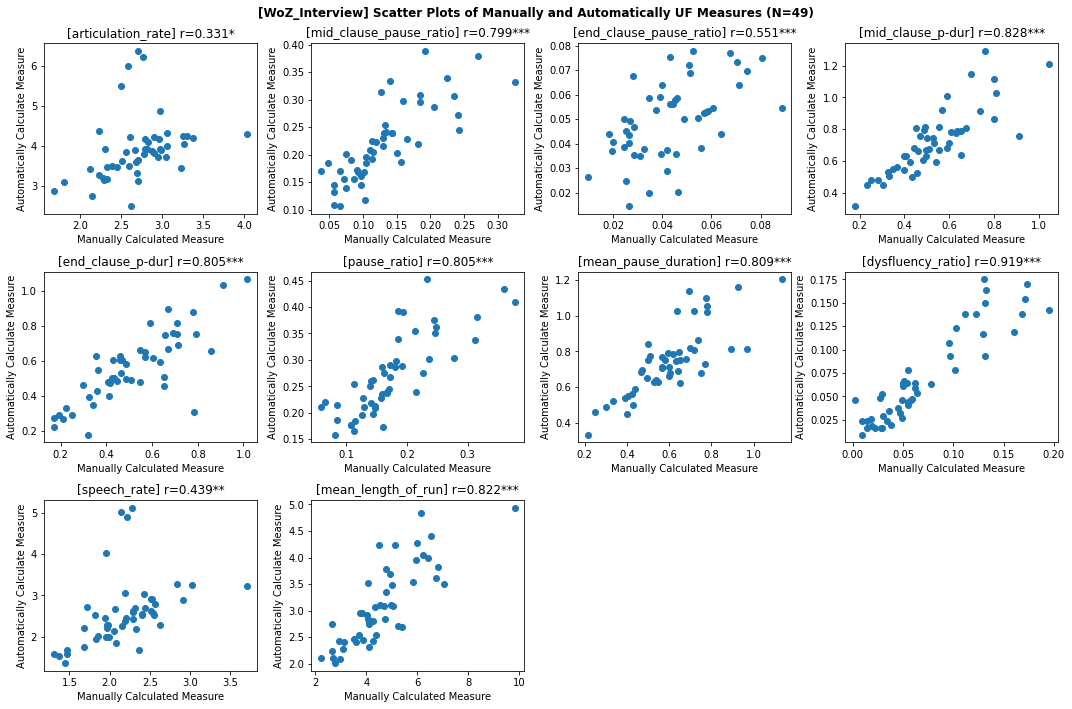

,r,p,sig
UF measure,,,
articulation_rate,0.331381,2.002237e-02,*
mid_clause_pause_ratio,0.799340,5.740964e-12,***
end_clause_pause_ratio,0.551077,4.072474e-05,***
mid_clause_p-dur,0.828073,2.132923e-13,***
end_clause_p-dur,0.805000,3.134038e-12,***
pause_ratio,0.805256,3.048041e-12,***
mean_pause_duration,0.808684,2.091358e-12,***
dysfluency_ratio,0.918623,1.399175e-20,***
speech_rate,0.438690,1.615684e-03,**


In [19]:
task = "WoZ_Interview"
rating_filter = [2, 3]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)

### 3.4. Advanced Speakers

The following code blocks conduct the analyses of *advanced speakers'* speech.

**Arg_Oly**

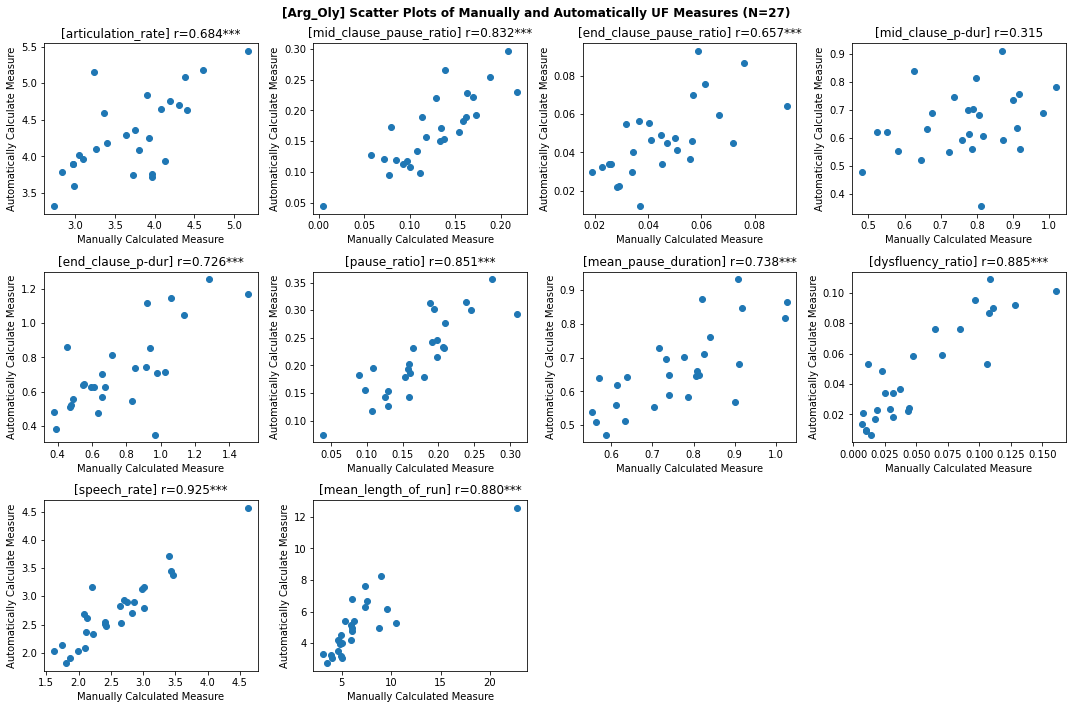

,r,p,sig
UF measure,,,
articulation_rate,0.683635,8.461439e-05,***
mid_clause_pause_ratio,0.831762,7.614326e-08,***
end_clause_pause_ratio,0.657169,1.960428e-04,***
mid_clause_p-dur,0.314663,1.099145e-01,
end_clause_p-dur,0.725706,1.837256e-05,***
pause_ratio,0.851122,1.845180e-08,***
mean_pause_duration,0.737800,1.124548e-05,***
dysfluency_ratio,0.885131,8.741604e-10,***
speech_rate,0.924572,5.666838e-12,***


In [20]:
task = "Arg_Oly"
rating_filter = [6, 7, 8]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)

**Cartoon**

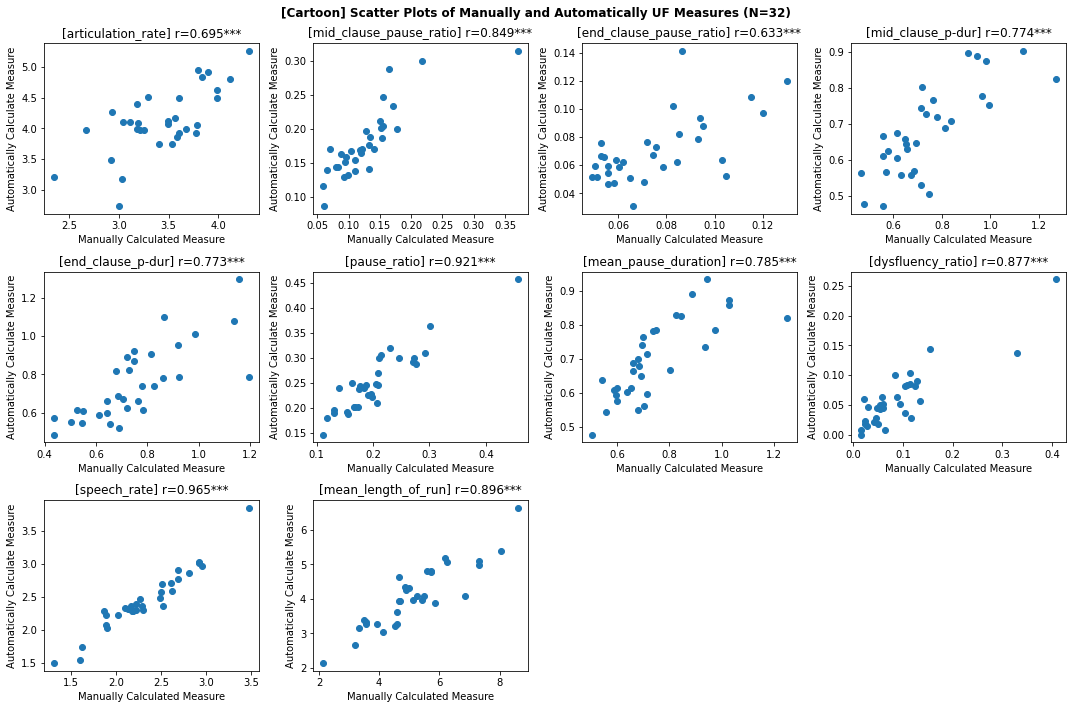

,r,p,sig
UF measure,,,
articulation_rate,0.695069,1.011651e-05,***
mid_clause_pause_ratio,0.848519,8.584378e-10,***
end_clause_pause_ratio,0.633331,9.998549e-05,***
mid_clause_p-dur,0.774454,1.979718e-07,***
end_clause_p-dur,0.773024,2.154000e-07,***
pause_ratio,0.920676,8.632796e-14,***
mean_pause_duration,0.785461,1.012536e-07,***
dysfluency_ratio,0.876777,4.725628e-11,***
speech_rate,0.964511,6.676968e-19,***


In [21]:
task = "Cartoon"
rating_filter = [6, 7, 8]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)

**RtSwithoutRAA**

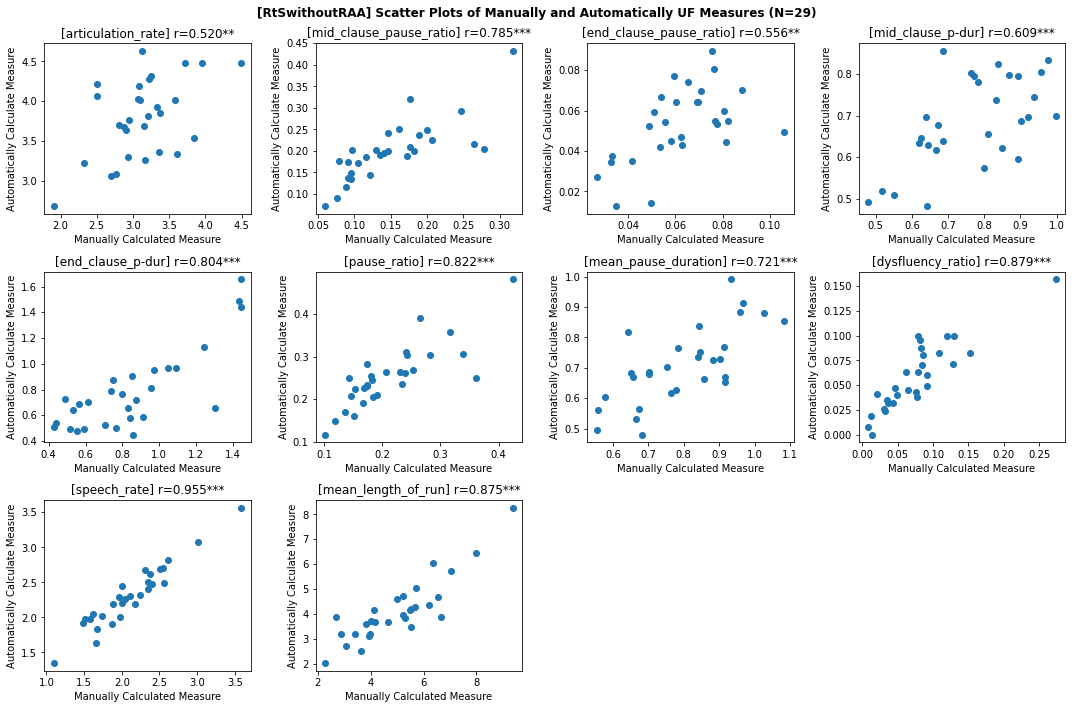

,r,p,sig
UF measure,,,
articulation_rate,0.519640,3.864565e-03,**
mid_clause_pause_ratio,0.785309,4.528370e-07,***
end_clause_pause_ratio,0.555646,1.752409e-03,**
mid_clause_p-dur,0.609071,4.539820e-04,***
end_clause_p-dur,0.804495,1.446517e-07,***
pause_ratio,0.821772,4.627802e-08,***
mean_pause_duration,0.721205,1.014715e-05,***
dysfluency_ratio,0.879372,3.407970e-10,***
speech_rate,0.955270,8.222970e-16,***


In [22]:
task = "RtSwithoutRAA"
rating_filter = [6, 7, 8]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)

**RtSwithRAA**

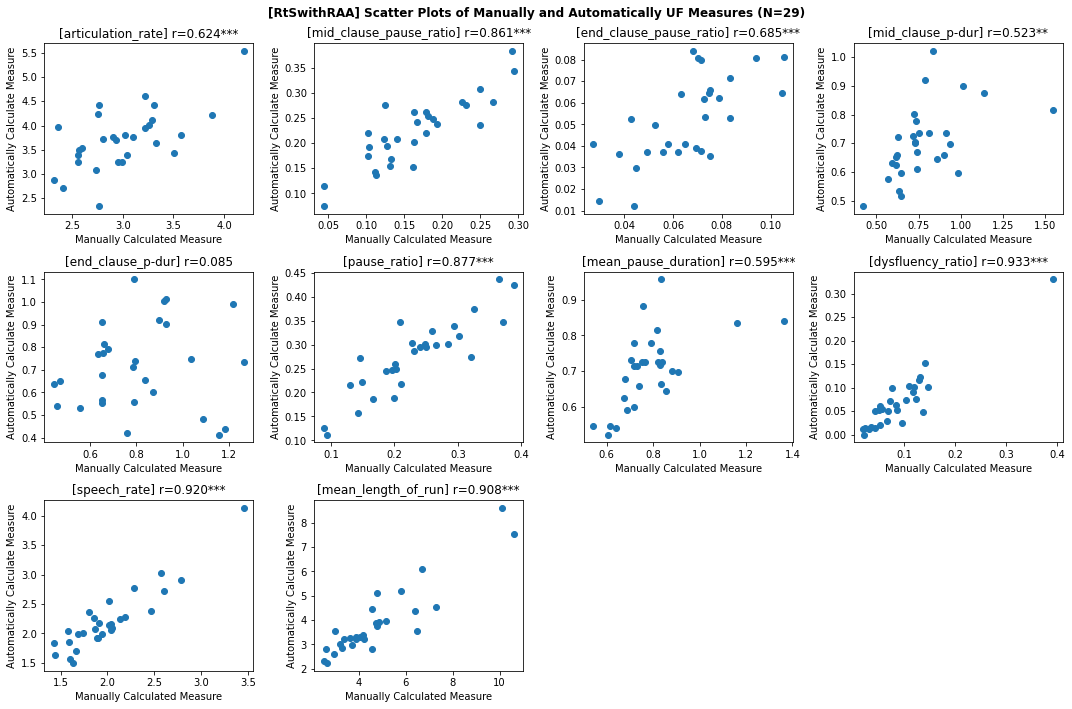

,r,p,sig
UF measure,,,
articulation_rate,0.623747,2.999897e-04,***
mid_clause_pause_ratio,0.860850,2.091021e-09,***
end_clause_pause_ratio,0.684505,4.216742e-05,***
mid_clause_p-dur,0.522653,3.628877e-03,**
end_clause_p-dur,0.085128,6.606177e-01,
pause_ratio,0.876779,4.469755e-10,***
mean_pause_duration,0.594690,6.683773e-04,***
dysfluency_ratio,0.933213,1.615129e-13,***
speech_rate,0.920353,1.610817e-12,***


In [23]:
task = "RtSwithRAA"
rating_filter = [6, 7, 8]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)

**WoZ_Interview**

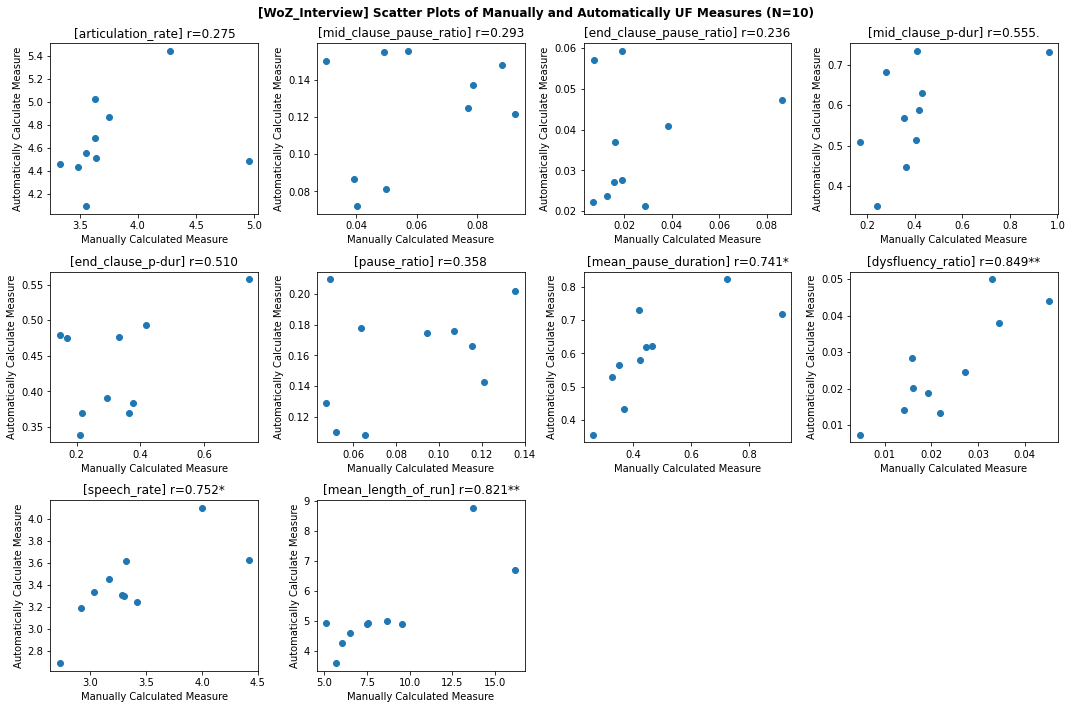

,r,p,sig
UF measure,,,
articulation_rate,0.274718,0.442391,
mid_clause_pause_ratio,0.292776,0.411684,
end_clause_pause_ratio,0.235832,0.511864,
mid_clause_p-dur,0.555400,0.095564,.
end_clause_p-dur,0.509576,0.132445,
pause_ratio,0.358494,0.309045,
mean_pause_duration,0.741412,0.014122,*
dysfluency_ratio,0.849097,0.001883,**
speech_rate,0.751891,0.012135,*


In [24]:
task = "WoZ_Interview"
rating_filter = [4, 5]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
correlation_analysis(task, df_uf_manu, df_uf_auto)